# Chatbot

In [51]:
import numpy as np
import re
import pandas as pd
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [52]:
data = pd.read_csv('./data/ChatbotData.csv')

data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [53]:
question = data['Q']
answer = data['A']

In [54]:
encoder_input, decoder_input, decoder_output = [], [], []

for stc in question:
    encoder_input.append(stc.split())

for stc in answer:
    decoder_input.append(("<start> "+stc).split())

for stc in answer:
    decoder_output.append((stc+" <end>").split())

print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[['12시', '땡!'], ['1지망', '학교', '떨어졌어'], ['3박4일', '놀러가고', '싶다']]
[['<start>', '하루가', '또', '가네요.'], ['<start>', '위로해', '드립니다.'], ['<start>', '여행은', '언제나', '좋죠.']]
[['하루가', '또', '가네요.', '<end>'], ['위로해', '드립니다.', '<end>'], ['여행은', '언제나', '좋죠.', '<end>']]


In [55]:
tokenizer_q = Tokenizer()
tokenizer_q.fit_on_texts(encoder_input)
encoder_input = tokenizer_q.texts_to_sequences(encoder_input)

tokenizer_ans = Tokenizer()
tokenizer_ans.fit_on_texts(decoder_input)
tokenizer_ans.fit_on_texts(decoder_output)

decoder_input = tokenizer_ans.texts_to_sequences(decoder_input)
decoder_output = tokenizer_ans.texts_to_sequences(decoder_output)

print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[[4751, 4752], [4753, 340, 542], [2582, 792, 25]]
[[1, 2996, 141, 1601], [1, 605, 1602], [1, 1324, 221, 48]]
[[2996, 141, 1601, 2], [605, 1602, 2], [1324, 221, 48, 2]]


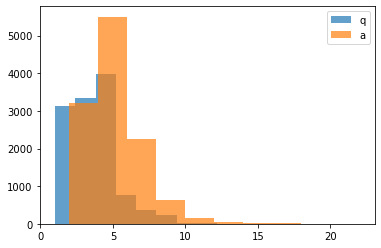

In [56]:
import matplotlib.pyplot as plt

len_q = []
for data in encoder_input:
    len_q.append(len(data))

len_a = []
for data in decoder_input:
    len_a.append(len(data))

plt.hist(len_q, label='q', alpha=0.7)
plt.hist(len_a, label='a', alpha=0.7)
plt.legend()
plt.show()

In [57]:
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_output = pad_sequences(decoder_output, padding="post")

print(encoder_input.shape)
print(decoder_input.shape)

print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

(11823, 15)
(11823, 22)
[[4751 4752    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [4753  340  542    0    0    0    0    0    0    0    0    0    0    0
     0]
 [2582  792   25    0    0    0    0    0    0    0    0    0    0    0
     0]]
[[   1 2996  141 1601    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   1  605 1602    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   1 1324  221   48    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
[[2996  141 1601    2    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [ 605 1602    2    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [1324  221   48    2    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


In [58]:
ans_to_index = tokenizer_ans.word_index
index_to_ans = tokenizer_ans.index_word

In [59]:
test_size = 5000
encoder_input_train = encoder_input[:-test_size]
decoder_input_train = decoder_input[:-test_size]
decoder_output_train = decoder_output[:-test_size]

encoder_input_test = encoder_input[-test_size:]
decoder_input_test = decoder_input[-test_size:]
decoder_output_test = decoder_output[-test_size:]

In [60]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

encoder_inputs = Input(shape=(15,))

encoder_embed = Embedding(len(tokenizer_ko.word_index)+1, 50)(encoder_inputs)

encoder_mask = Masking(mask_value=0)(encoder_embed)

encoder_outputs, h_state, c_state = LSTM(50, return_state=True)(encoder_mask)

In [61]:
decoder_inputs = Input(shape=(22,))

decoder_embed = Embedding(len(tokenizer_en.word_index)+1, 50)(decoder_inputs)

decoder_mask = Masking(mask_value=0)(decoder_embed)

decoder_lstm = LSTM(50, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_mask, initial_state=[h_state, c_state])

decoder_dense = Dense(len(tokenizer_en.word_index)+1, activation='softmax')

decoder_softmax_outputs = decoder_dense(decoder_outputs)

In [63]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_output_train, validation_data = ([encoder_input_test, decoder_input_test], decoder_output_test), batch_size = 128, epochs = 5)

Train on 6823 samples, validate on 5000 samples
Epoch 1/5
6823/6823 [==============================] - 82s 12ms/sample - loss: 1.2637 - acc: 0.8452 - val_loss: 1.7522 - val_acc: 0.8142
Epoch 2/5
6823/6823 [==============================] - 71s 10ms/sample - loss: 1.2266 - acc: 0.8452 - val_loss: 1.7502 - val_acc: 0.8142
Epoch 3/5
6016/6823 [=========================>....] - ETA: 7s - loss: 1.2052 - acc: 0.8454

KeyboardInterrupt: 

In [ ]:
encoder_model = Model(encoder_inputs, [h_state, c_state])

encoder_h_state = Input(shape=(50,))
encoder_c_state = Input(shape=(50,))

pd_decoder_outputs, pd_h_state, pd_c_state = decoder_lstm(decoder_mask, initial_state=[encoder_h_state, encoder_c_state])
pd_decoder_softmax_outputs = decoder_dense(pd_decoder_outputs)

decoder_model = Model([decoder_inputs] + [encoder_h_state, encoder_c_state], [pd_decoder_softmax_outputs] + [pd_h_state, pd_c_state])



In [ ]:
input_stc = input()
token_stc = input_stc.split()
encode_stc = tokenizer_ko.texts_to_sequences([token_stc])
pad_stc = pad_sequences(encode_stc, maxlen=22, padding="post")

states_value = encoder_model.predict(pad_stc)

predicted_seq = np.zeros((1,1))
predicted_seq[0, 0] = en_to_index['<start>']

decoded_stc = []

while True:
    output_words, h, c = decoder_model.predict([predicted_seq] + states_value)

    predicted_word = index_to_en[np.argmax(output_words[0,0])]  

    if predicted_word == '<end>':
        break

    decoded_stc.append(predicted_word)

    predicted_seq = np.zeros((1,1))
    predicted_seq[0, 0] = np.argmax(output_words[0,0])
-
    states_value = [h, c]

print(' '.join(decoded_stc))